In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt 
from spice_net import *

import PySpice
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

In [2]:
# Generate the uniform dataset 
num_pts = 15
lh = 2
# eval_set = np.array(np.meshgrid(np.arange(-lh, lh, 2*lh/num_pts), np.arange(-lh, lh, 2*lh/num_pts))).reshape(2,-1).T 
# eval_bias = np.hstack((eval_set, np.ones((eval_set.shape[0], 1))))
# N = eval_bias.shape[0]
eval_set = np.linspace(-lh, lh, num_pts)[:, None]
eval_bias = np.stack((np.linspace(-lh, lh, num_pts), np.ones(num_pts))).T
nodes = 20 

In [3]:
# Parameters
nodes = 6
edge_prob = .8
diode_prob = .0

bias = True

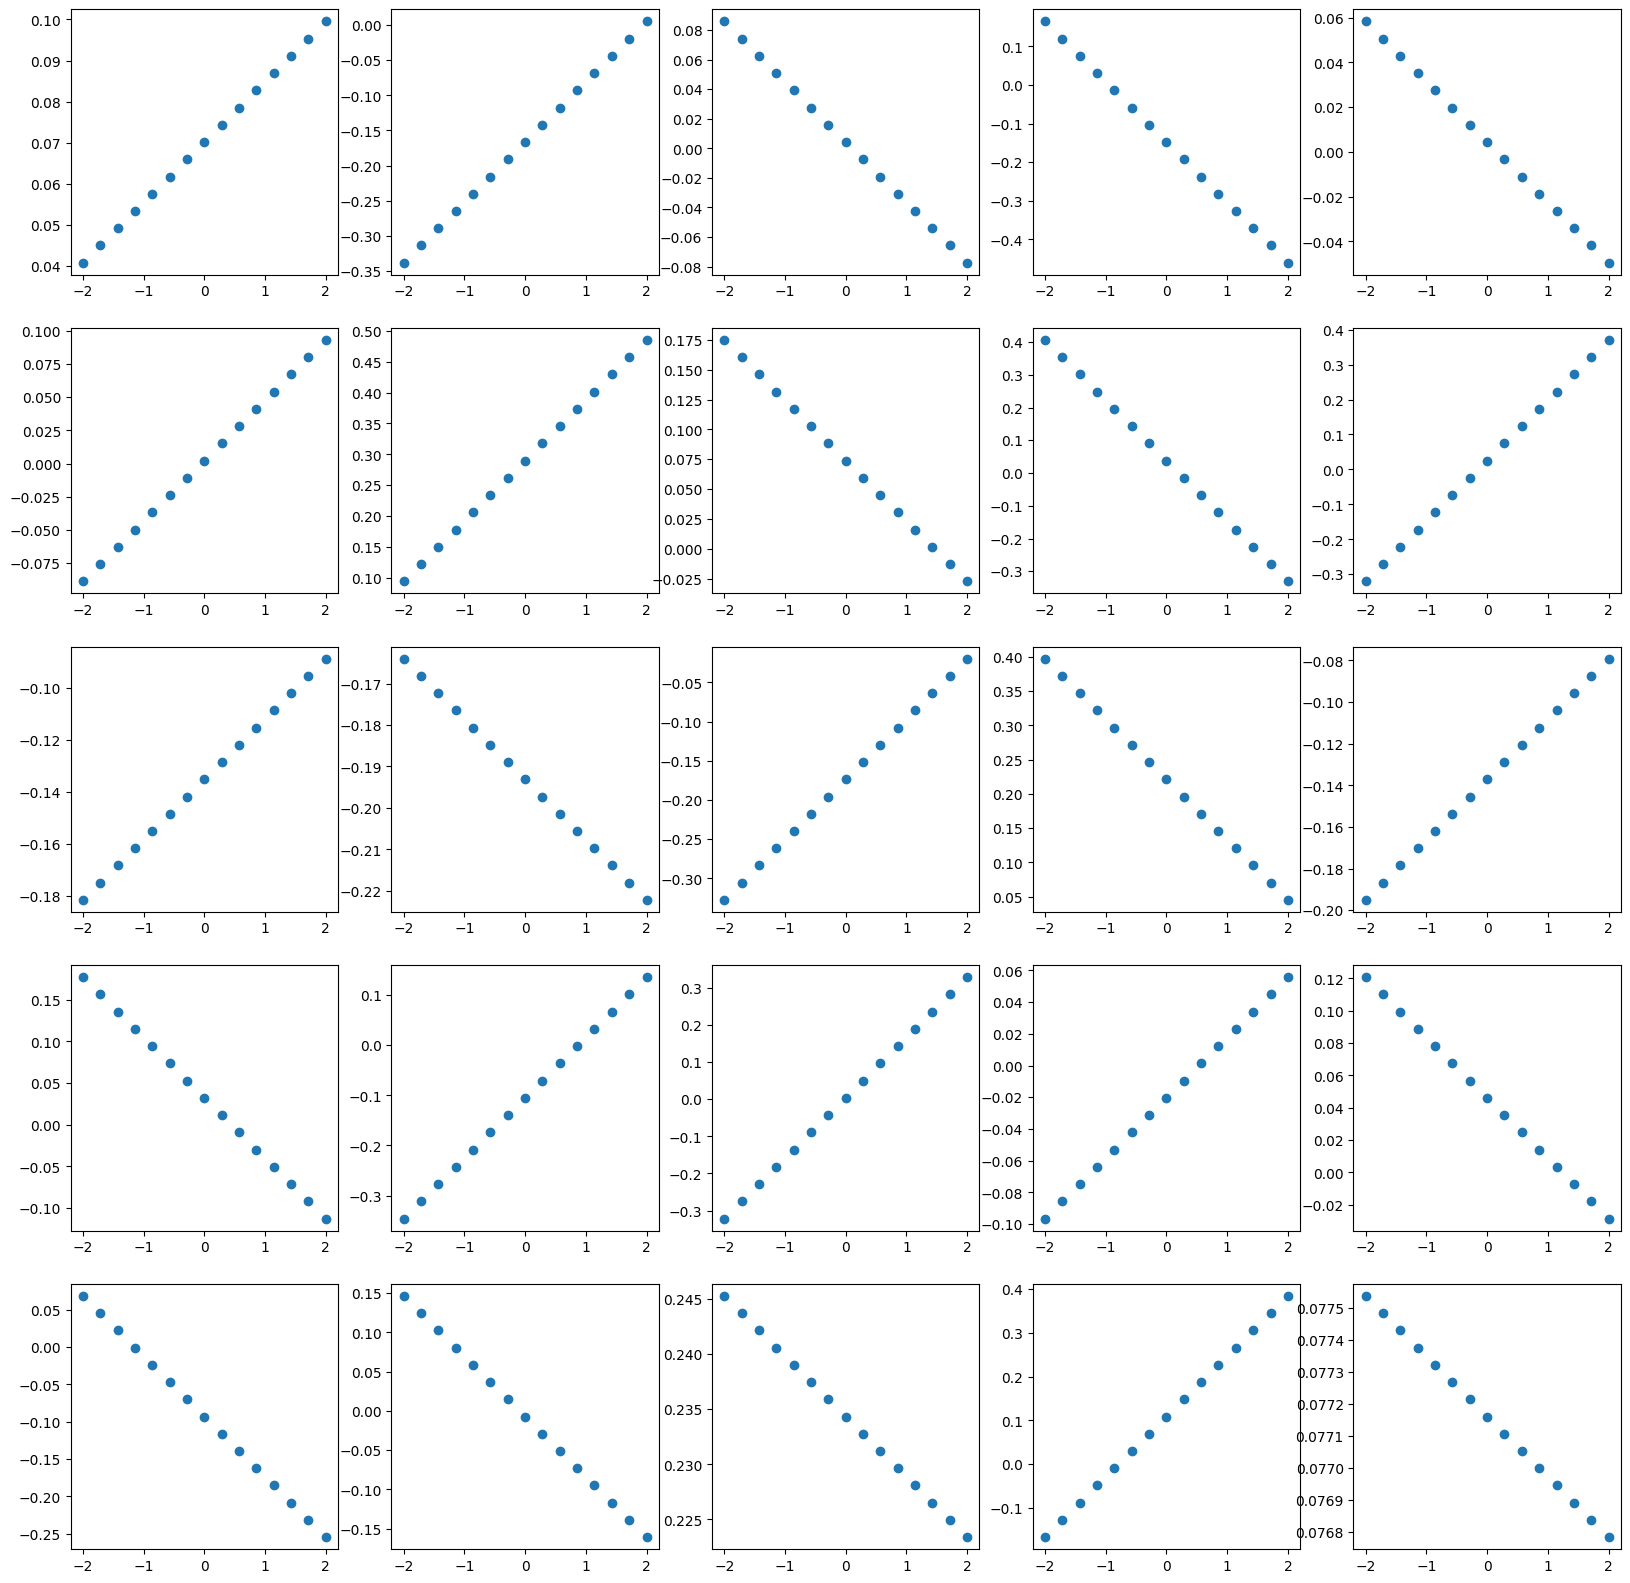

In [4]:
# Generate a ton of randomly initialized networks and see how they do
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
fig
out_nodes = 1
if bias:
    dset = eval_bias
else:
    dset = eval_set

in_nodes = dset.shape[1]
nets = []

for row in axs:
    for subp in row:
        con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
        diodes, res = 0, 0
        for u, v in con_graph.edges():
            if np.random.rand() < diode_prob:
                diodes += 1
                con_graph[u][v]['type'] = 'diode'
                con_graph[u][v]['weight'] = 1./np.random.rand() 
            else:
                con_graph[u][v]['type'] = 'resistor'
                con_graph[u][v]['weight'] = 1./np.random.rand() 
                res += 1

        node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
        node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
        node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

        rand_net = NonLinearNetwork('rand2', con_graph, node_cfg)

        res = np.empty((num_pts, out_nodes))

        for i in range(num_pts):
            res[i] = rand_net.predict(dset[i])[0]

        subp.scatter(eval_set, res)